We will use the CubicSpline method from **scipy.interpolate** to test the 
effects of different end conditions.

The argument to CubicSpline is

    CubicSpline(x, y, axis=0, bc_type='not-a-knot', extrapolate=None)
    x is the spline knots
    y is the interpolation data
    bc_type can be "natural", "clamped", "not-a-knot", "periodic",or a 2-tuple,
    ((deriv order at left,value at left),(derivative order at right, value at right))

For example, ((1,4),(2,3))
says that $S^\prime(a)=4$ and $S^\prime\prime(b)=3$ for $S(x)$ defined 
on [a,b].


<function matplotlib.pyplot.show>

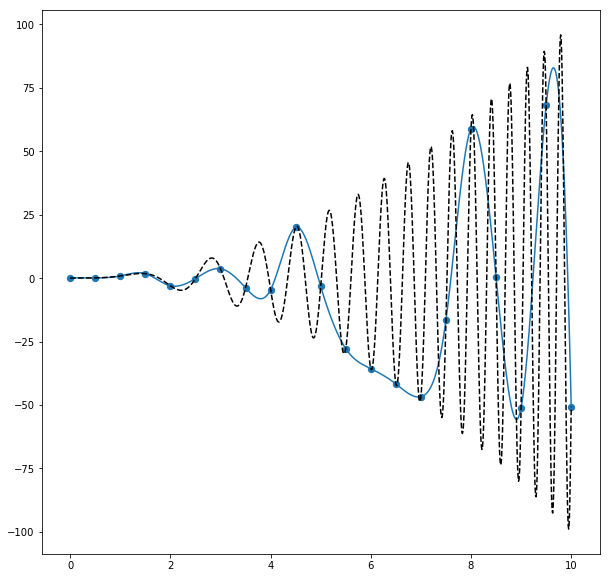

In [2]:
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10


def fx(x):
    return x**2*np.sin(x**2)

#generate our data
x=np.linspace(0,10,21)
y=fx(x)
cs=CubicSpline(x,y)
plotpt=np.linspace(0,10,1000)
yp=plotpt*np.sin(plotpt)
plt.plot(plotpt,cs(plotpt))
plt.plot(plotpt,fx(plotpt),linestyle='--',c='black')
plt.scatter(x,y,s=40)
plt.show


## To Do
Modify the above code to plot the error between $f(x)$ and $S(x)$.  
Of the basic types, which gives you the smallest error(skip periodic).

Now use the exact derivatives of $f(x)$ to specify the end conditions.
(There are 4 combinations).  Are these errors smaller than the defaults?  
Which is the best in the max norm on [0,10]?


## Spline Basis Functions  (B-Splines)

We'd like to write our spline interpolation problem as a general linear
algebra problem.  When we were dealing with polynomial interpolation, we
had different choices of bases for interpolation of $f(x)$ on $[a,b]$.

We could use the monomials, so write $f(x)=\sum \alpha_i x^i$, and plug in
$(x_i,f_i)$ to solve the system.

We could use the Lagrange polynomials, and write $f(x) = \sum \alpha_i L_i(x)$, where
$$
L_i(x) = \Pi{j\neq i} \frac{x-x_j}{x_i - x_j}
$$

We could use the Newton Basis, where $f(x)=\sum \alpha_i N_i(x)$,
$$
N_0(x) = 1, 
N_i(x) = \Pi_{j<i} (x-x_i)
$$

### To Do: (SKIP THIS)

Think about the linear algrebra versions of Lagrange and Newton Interpolation.  What do the corresponding matrix problems $B(\alpha)=f$
look like?  Write a code to find the Newton interpolant using the linear algebra perspective.  

In [3]:
# build matrix for datapoint x_i
def newton_inter(x_i,f_i):
    matrix=np.zeros((x_i.size,x_i.size))
    rhs = f_i
    #build right hand side f x_i
    matrix[:,0]=1
    for i in range(1,x_i.size):
        matrix[i:,i]=matrix[i:,i-1]*(x_i[i:]-x_i[i-1])
    print(matrix)
#coefficients=np.linalg.solve(matrix,rhs)
    coeff=np.linalg.solve(matrix,rhs)
    return coeff
x_i=np.linspace(0,1,5)
f_i=x_i**3
coeff = newton_inter(x_i,f_i)
print(coeff)

[[ 1.       0.       0.       0.       0.     ]
 [ 1.       0.25     0.       0.       0.     ]
 [ 1.       0.5      0.125    0.       0.     ]
 [ 1.       0.75     0.375    0.09375  0.     ]
 [ 1.       1.       0.75     0.375    0.09375]]
[ 0.      0.0625  0.75    1.      0.    ]


We'd like to do the same thing for spline function interpolation, we have 
a set of functions such that

$$
S(x) = \sum_{i=1}^n c_i B_i(x)
$$

Recall our first definition of splines:

Given "knots" $a=t_0,t_1,\ldots t_n=b$ and an order $k$, and
let $S(x)$ be an element of the spline space $\mathcal{S}_{n,k}[a,b]$

1. Let $x \in I_i=[t_i,t_{i+1})$.  Then $S(x)\in \mathbb{P}_{k-1}(I_i)$.
2. $S(x) \in C^{k-2}[a,b]$.

What is a spanning set (and maybe) a basis for $\mathcal{S}_{n,k}$?

The set $\{(x-t_i)_+^l\}$, $0\leq l \leq k_1$, where
$$
(x-t_i)_+ = (x-t_i), \quad x\geq t_i, \quad 0 ~\text{otherwise}
$$



## To Do:
* Prove that $\mathbb{P}_{k-1}\subset \mathcal{S}_{n,k}$
* Prove that $\{1,x,x^2,\ldots,x^{k-1},(x-t_1)_+^{k-1},(x-t_{n-1})_+^{k-1}\}$ is a basis for $\mathcal{S}_{n,k}$.  Hint: consider an arbitrary linear combination and apply the linear functional 
$$ f_i(S)=\frac{1}{(k-1)!} \left(S^{(k-1)}(t_i^+)-S^{(k-1)}(t_i^-)\right)
$$

## This is not the basis you are looking for...



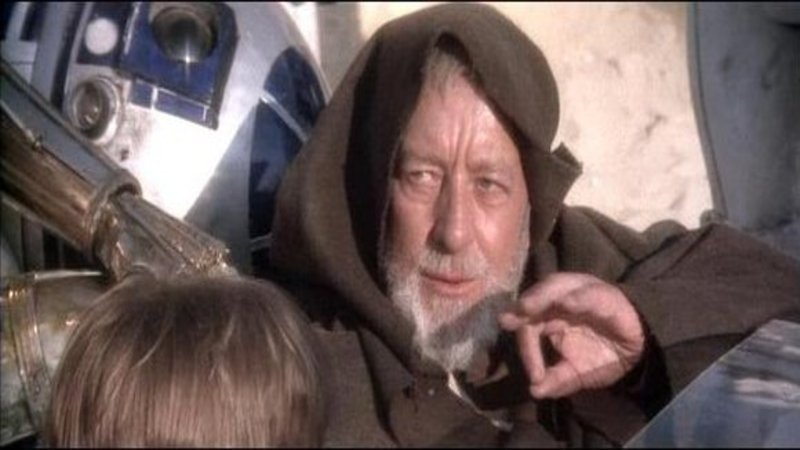

In [5]:

from IPython.display import Image
Image(filename='./obi-wan.jpg',width=400)

## Why?

The **monomial basis functions** are non-local.  Consider
$$
S(x) =  \begin{array}{ll} 0, & -1\leq x<0 \\
\frac{1}{2}x^2, & 0 \leq x < 1 \\
2x-\frac{1}{2}x^2-\frac{3}{2}, & 1\leq x < 2 \end{array} 
$$.

* You will do a lot of unneccesary work to evaluate $S(x)$ on [-1,0]
* If two knots are close together, $(x-t_i)_+^{k-1}$ and $(x-t_{i+1})_+^{k-1}$ may be problematic

We will propose a set of basis functions and verify that they satisfy our
properties.

Let 
$$
B_{i,0}(x) = \begin{array}{ll} 1 & x_i \in [t_i,t_{i+1}] \\
                           0 & \text{otherwise}  \end{array}
                           $$
We plot $B_{i,0}$ below:                          

In [ ]:
def B0(x,x0=0,x1=1):
    return (x>=x0)*(x<x1)


pts=np.linspace(-2,2,100)
plt.plot(pts,B0(pts))

We define smoother $B$-functions by recursion:  Let
$$
B_{i,n}(x)= \frac{(x-t_i)}{t_{i+n}-t_i} B_{i,n-1}(x) + \frac{(t_{i+n+1}-x)}{t_{i+n+1}-t_{i+1}} B_{i+1,n-1}(x)
$$

We write a recursive code to plot $B_{0,1}$ for $t_0=0$ and $t_1=1$.


In [ ]:
def Brecur(x,i,knot,degree):
    #knot is vector of t_i locations
    #i is knot basis function
    if degree==0:
        return B0(x,knot[i],knot[i+1])
    else:
        fac1=(x-knot[i])/(knot[i+degree]-knot[i])
        fac2=(knot[i+degree+1]-x)/(knot[i+degree+1]-knot[i+1])
        return fac1*Brecur(x,i,knot,degree-1)+fac2*Brecur(x,i+1,knot,degree-1)
    
#Linear test
knot=np.array([0,1,2,3])
x=np.linspace(-2,4,1000)
B1=Brecur(x,0,knot,1)
B2=Brecur(x,1,knot,1)
plt.plot(x,B1)
plt.plot(x,B2)
plt.axvline(1,c='r')
plt.axvline(2,c='r')
plt.show()

Convince yourself that any linear function on [1,2] can be written as a combination of $B_{0,1}$ and $B_{1,1}$.

## To Do

Let $S(x)$ be the interpolating linear spline of $f(x)=sin(x)$, with
data points at $x=0,\pi/4,\pi/2$.  Write $S(x)$ as a linear combination
of the appropriate $B_(i,1)$.  Verify your answer by plotting.


We now plot the basis functions for cubic splines with specified knots.

In [ ]:
knot=np.arange(10)
degree=3
x=np.linspace(-1,8,1000)
for i in range(4):
    B=Brecur(x,i,knot,3)
    plt.plot(x,B)
plt.show()

## To Do

What is the **support** of $B_{i,n}$?  

In [ ]:
#Support of a function is where it is not zero

## Inforcing End Conditions

We saw earlier to specify the spline, we need to set conditions involving
derivatives at the endpoints and continuity at interpolation points.

# To Do
Write a function to compute the first derivates of the $B(i,p)$. 
Plot $B(0,2)$ and its derivative.

Hint: Differentiate the recursive formulation.



Let $f(x)=x^3+x+1=S(x)$ on [0,1].  Write this as a linear combination of 
the appropriate $B_{i,3}$ (don't solve for the coefficients). How big is the system?

Plugging in $S(0)=f(0)$ and $S(1)=f(1)$ gives us 2 equations.  Our
end conditions give us two more conditions.  Use $S'(0)=f'(0)$ and $S'(1)=f'(1)$ and your earlier code to produce $S(x)$ and verify your code.



In [ ]:
#We have B0 B1 B2 B3 all have support that intersects 0,1
#We make a big knot vector to cover them all
knot = np.arange(-3,6)
print(knot)
x = np.array([[0],[1]])
B_0 = Brecur (x,0,knot,3)
B1 = Brecur(x,1,knot,3)
B2 = Brecur(x,2,knot,3)
B3 = Brecur(x,3,knot,3)
dB0 = dBspline(x,0,knot,3)
dB1 = dBspline(x,1,knot,3)
dB2 = dBspline(x,2,knot,3)
dB3 = dBspline(x,3,knot,3)
print(dB0)
A=np.zeros((4,4))
##whar are the first two rows of the matrix?
for i in range (2):
    A[i]=[B_0[i],B1[i],B2[i],B3[i]]
    A[i+2]=[dB0[i],dB1[i],dB2[i],dB3[i]]
print(A)
A[2]=[dB0[0],dB1[0],dB2[0],dB3[0]]
A[3]=[dB0[1],dB1[1],dB2[1],dB3[1]]

rhs=np.zeros((4,1))
rhs[0]=1#f(0)=1
rhs[1]=3#f(1)=3
rhs[2]=1#df=3x**2+1 df(0)=1
rhs[3]=4#df(1)=4
coeff=np.linalg.solve(A,rhs)
print(coeff)